In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua_thoi_tiet.csv"

## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

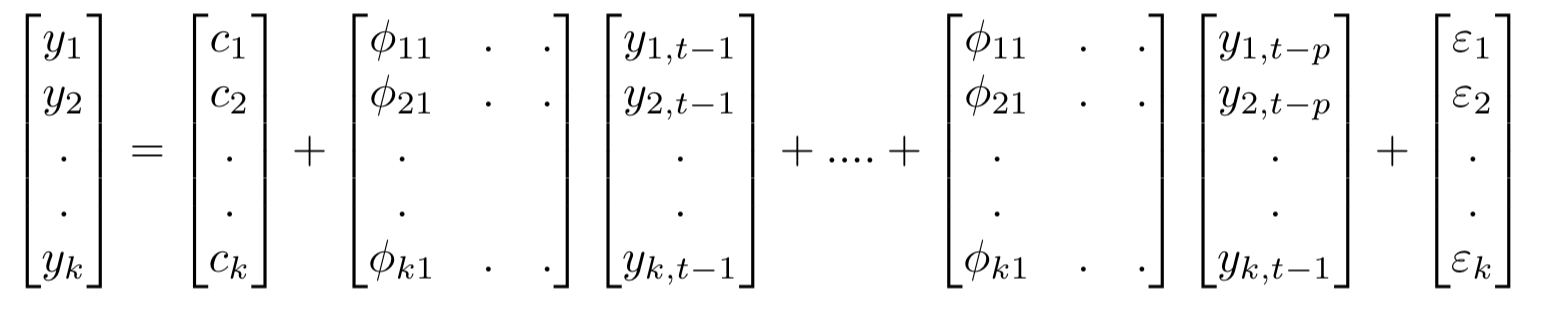

In [3]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [4]:
df.set_index('date', inplace=True)

In [5]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2007-03-08,4800,28.277778,25.388889,34.722222,0.831,114,7.6,1011.0
2007-03-09,4900,28.277778,25.388889,34.722222,0.831,114,7.6,1011.0
2007-03-12,4900,30.000000,25.000000,37.000000,0.831,112,10.6,1011.0
2007-03-13,4900,28.777778,26.000000,35.611111,0.831,127,10.6,1011.0
2007-03-14,4900,28.000000,25.000000,34.000000,0.831,137,9.7,1011.0


<Axes: >

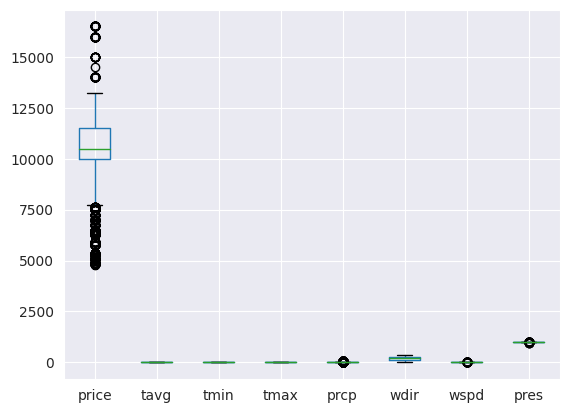

In [6]:
df.boxplot()

In [7]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 578


<Axes: >

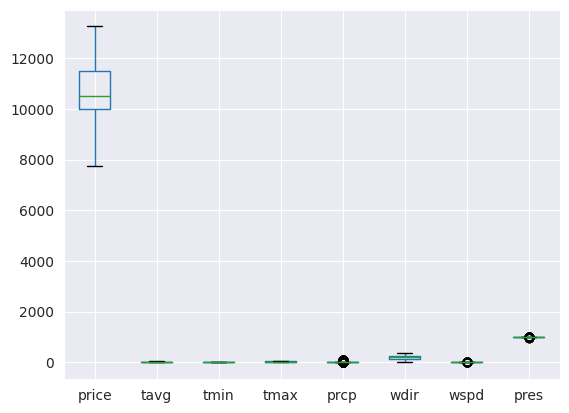

In [8]:
df.boxplot()

In [9]:
df = df.dropna()

In [10]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
price,1.000000,0.410797,0.413297,0.397957,-0.231933,-0.003994,-0.204454,-0.281839
tavg,0.410797,1.000000,0.998162,0.998514,-0.329943,0.105905,-0.521991,-0.419981
tmin,0.413297,0.998162,1.000000,0.995815,-0.332704,0.116697,-0.515098,-0.430837
tmax,0.397957,0.998514,0.995815,1.000000,-0.323798,0.100518,-0.524617,-0.406662
prcp,-0.231933,-0.329943,-0.332704,-0.323798,1.000000,-0.104537,0.102153,0.167631
wdir,-0.003994,0.105905,0.116697,0.100518,-0.104537,1.000000,-0.003497,-0.229445
wspd,-0.204454,-0.521991,-0.515098,-0.524617,0.102153,-0.003497,1.000000,0.165377
pres,-0.281839,-0.419981,-0.430837,-0.406662,0.167631,-0.229445,0.165377,1.000000


In [11]:
fillter_feature = ['price', 'tavg', 'tmax', 'pres']
df = df[fillter_feature]

In [12]:
from google.colab import files
df.to_csv('./gia_lua_thoi_tiet.csv')
files.download('./gia_lua_thoi_tiet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmax,pres
price,1.000000,0.410797,0.397957,-0.281839
tavg,0.410797,1.000000,0.998514,-0.419981
tmax,0.397957,0.998514,1.000000,-0.406662
pres,-0.281839,-0.419981,-0.406662,1.000000


<Axes: xlabel='date'>

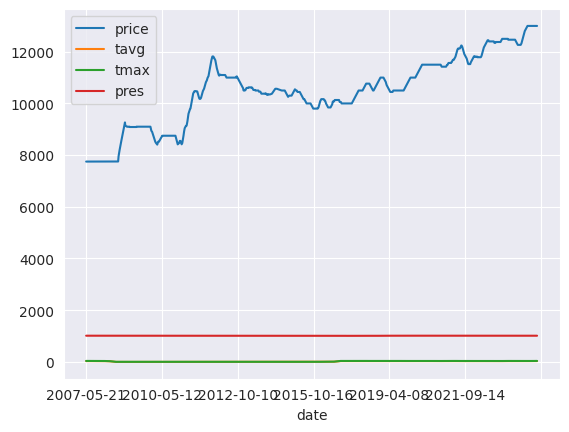

In [ ]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [ ]:
nobs = 360
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(2615, 4)
(360, 4)


In [ ]:
from google.colab import files


## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6366
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.4641. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8066
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3772. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4834
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7633
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

## Train model

In [ ]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -16.782818363654766
BIC :  -16.737902525418864
FPE :  5.144161586102077e-08
HQIC:  -16.766548387130992 

Lag Order = 2
AIC :  -16.862313011050926
BIC :  -16.781438825118972
FPE :  4.7510604320846406e-08
HQIC:  -16.83301718224616 

Lag Order = 3
AIC :  -16.89389252284693
BIC :  -16.7770371396327
FPE :  4.603369568592888e-08
HQIC:  -16.85156205739856 

Lag Order = 4
AIC :  -16.89606666302672
BIC :  -16.74320720937862
FPE :  4.593373942723883e-08
HQIC:  -16.840692767248377 

Lag Order = 5
AIC :  -16.88951516472494
BIC :  -16.700628743892636
FPE :  4.623569241374005e-08
HQIC:  -16.821089035593037 

Lag Order = 6
AIC :  -16.89562520312239
BIC :  -16.670688894723366
FPE :  4.5954095892586084e-08
HQIC:  -16.814138028262654 

Lag Order = 7
AIC :  -16.89706540268795
BIC :  -16.636056262674032
FPE :  4.588802111654257e-08
HQIC:  -16.802508360361923 

Lag Order = 8
AIC :  -16.89211125227352
BIC :  -16.595006312897315
FPE :  4.6116001783964453e-08
HQIC:  -16.78447551136504 

L

In [ ]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-12.33,-12.33,4.399e-06,-12.33
1,-16.78,-16.73,5.183e-08,-16.76
2,-16.86,-16.77*,4.784e-08,-16.83
3,-16.89,-16.77,4.631e-08,-16.84
4,-16.89,-16.74,4.614e-08,-16.84
5,-16.88,-16.69,4.649e-08,-16.81
6,-16.89,-16.66,4.615e-08,-16.81
7,-16.89,-16.63,4.603e-08,-16.80
8,-16.89,-16.59,4.620e-08,-16.78
9,-16.89,-16.55,4.638e-08,-16.76


In [ ]:
model_var = model.fit(48)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     02:50:54
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -16.1123
Nobs:                     2566.00    HQIC:                  -17.2342
Log likelihood:           9138.28    FPE:                1.73228e-08
AIC:                     -17.8724    Det(Omega_mle):     1.29610e-08
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.125457         0.083668            1.499           0.134
L1.price          0.811512         0.020528           39.532           0.000
L1.tavg          -5.499755         4.793153           -1.147           0.251

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
tavg   : 2.0
tmax   : 2.0
pres   : 2.0


In [ ]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

48


array([[ 0.00000000e+00, -4.44444444e-02, -2.22222222e-02,
         1.53333333e-01],
       [ 0.00000000e+00, -3.70370370e-03, -4.44444444e-02,
         1.31111111e-01],
       [ 0.00000000e+00, -1.97530864e-02,  2.22222222e-02,
         7.55555556e-02],
       [ 0.00000000e+00, -3.82716049e-02,  0.00000000e+00,
         2.22222222e-02],
       [ 0.00000000e+00,  9.87654321e-03,  0.00000000e+00,
        -1.77777778e-02],
       [ 0.00000000e+00,  2.46913580e-03,  0.00000000e+00,
        -8.88888889e-03],
       [ 0.00000000e+00, -1.35802469e-02, -2.22222222e-02,
         7.77777778e-02],
       [ 0.00000000e+00,  4.19753086e-02,  8.88888889e-02,
         8.00000000e-02],
       [ 0.00000000e+00, -3.82716049e-02,  2.22222222e-02,
         4.88888889e-02],
       [ 0.00000000e+00, -4.44444444e-02, -4.44444444e-02,
         3.77777778e-02],
       [ 0.00000000e+00, -4.19753086e-02, -4.44444444e-02,
         3.55555556e-02],
       [ 0.00000000e+00, -4.44444444e-02, -2.22222222e-02,
      

In [ ]:
import joblib
joblib.dump(model_var, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [ ]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,tavg_2d,tmax_2d,pres_2d
date,,,,
2022-04-29,19.377174,0.080920,0.058384,-0.070224
2022-05-04,18.242960,0.063674,0.062925,-0.031323
2022-05-05,17.881702,0.057232,0.058164,-0.044757
2022-05-06,16.299477,0.061176,0.054139,-0.122343
2022-05-09,17.393943,0.034058,0.011855,-0.104125
...,...,...,...,...
2024-05-08,1.684692,0.005201,0.005594,-0.001129
2024-05-10,1.632040,0.005518,0.005986,-0.000926
2024-05-13,1.601730,0.005050,0.005359,-0.000464


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2022-04-29,11986.043840
2022-05-04,12004.286801
2022-05-05,12022.168502
2022-05-06,12038.467980
2022-05-09,12055.861923
...,...
2024-05-08,12965.489025
2024-05-10,12967.121066
2024-05-13,12968.722796


### Đánh giá mô hình VAR

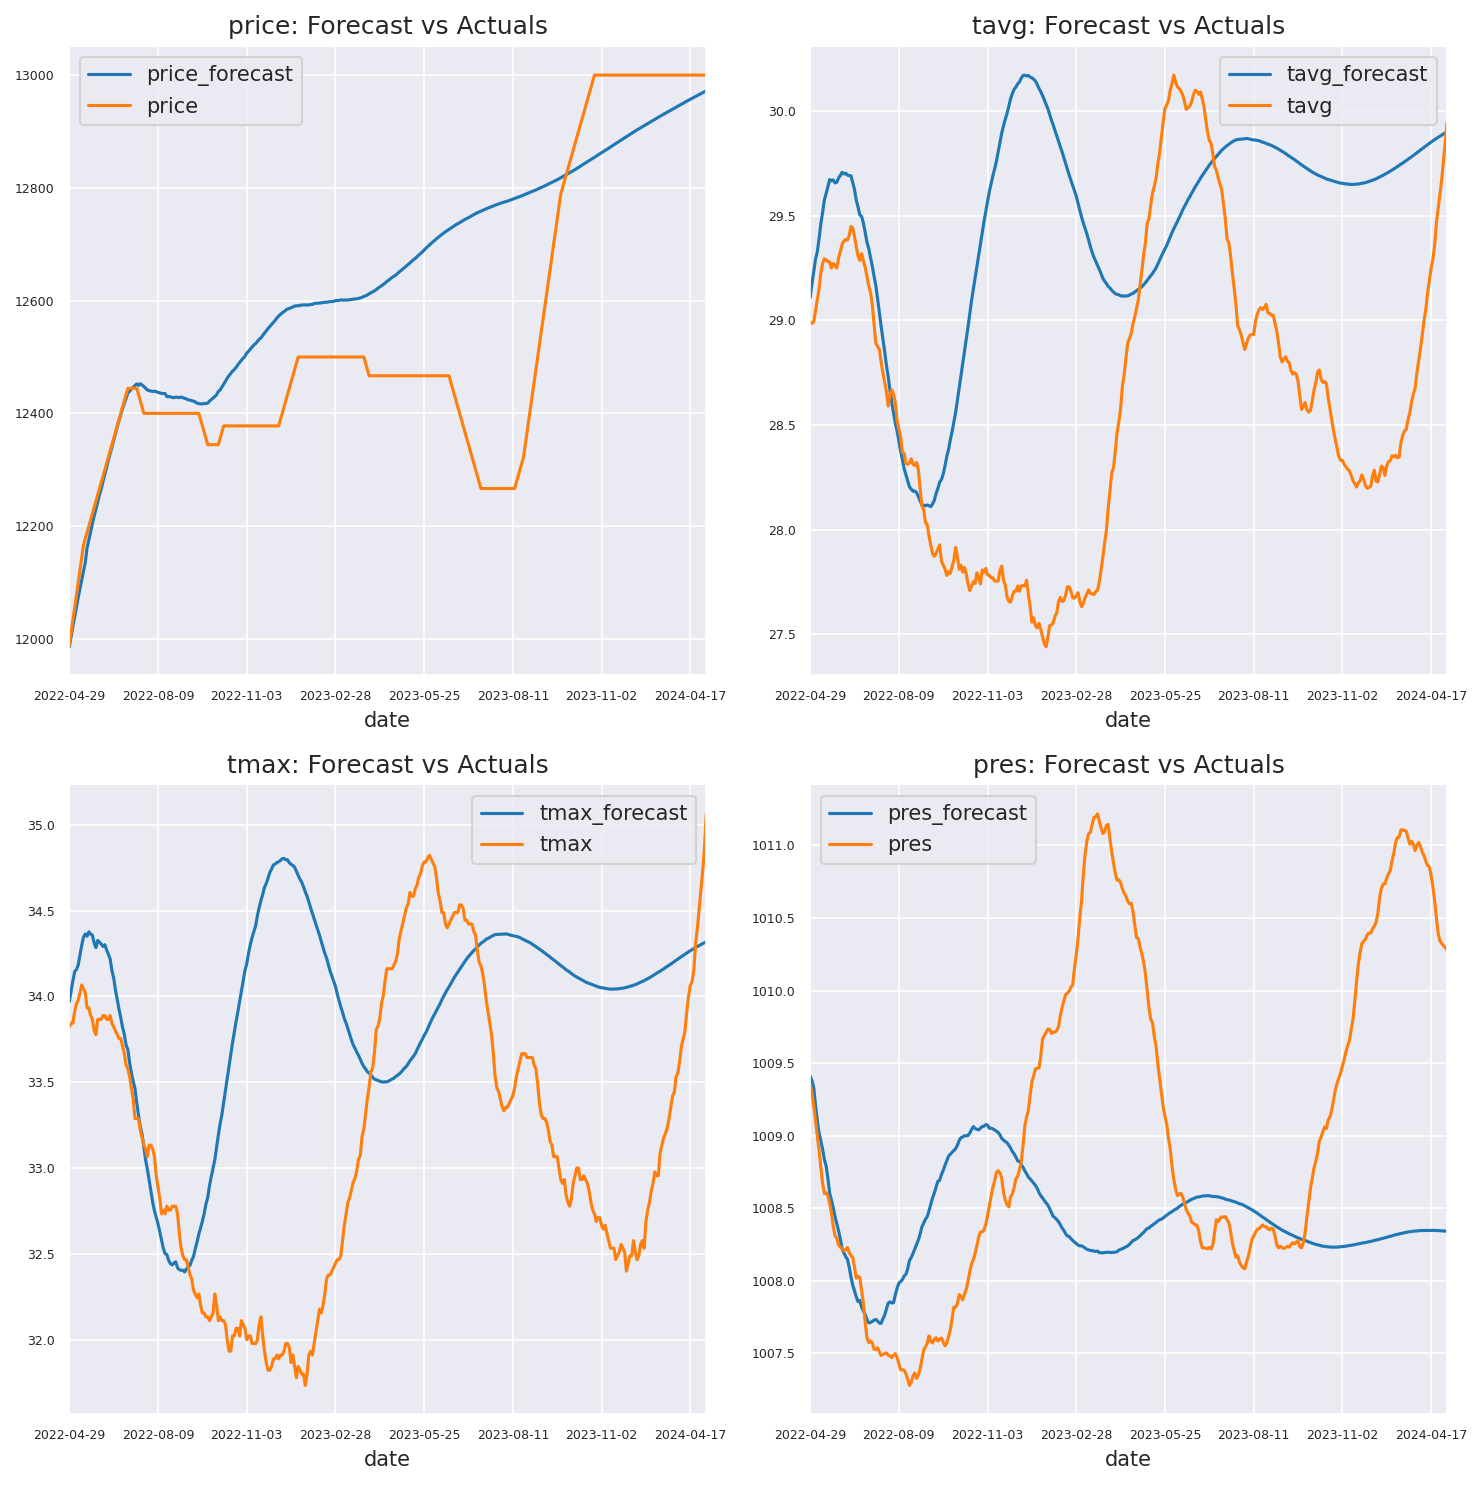

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) * 100  # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  1.1577
rmse   :  198.2675


## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
columns_train = fillter_feature

In [ ]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15553.720, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20153.674, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15576.163, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18003.812, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15539.105, Time=2.72 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15558.589, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15537.059, Time=2.76 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=15538.218, Time=0.94 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=15539.120, Time=1.53 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15539.048, Time=2.88 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15537.227, Time=1.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=15537.062, Time=1.44 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=15540.566, Time=3.79 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=15537

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (3, 0, 1)
{'p': 3, 'q': 1, 'RMSE Open': 79.43618992922264}
 Running for (1, 1, 1)
{'p': 1, 'q': 1, 'RMSE Open': 110.09204821713158}
 Running for (0, 1, 1)
{'p': 0, 'q': 1, 'RMSE Open': 250.02782136976649}
 Running for (3, 0, 2)
{'p': 3, 'q': 2, 'RMSE Open': 79.14463624689192}


In [ ]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(3,1),trends = 'n').fit( disp=False)


In [ ]:
result = model_varma.forecast(len(df_test))

In [ ]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  1.0236
rmse   :  167.0803


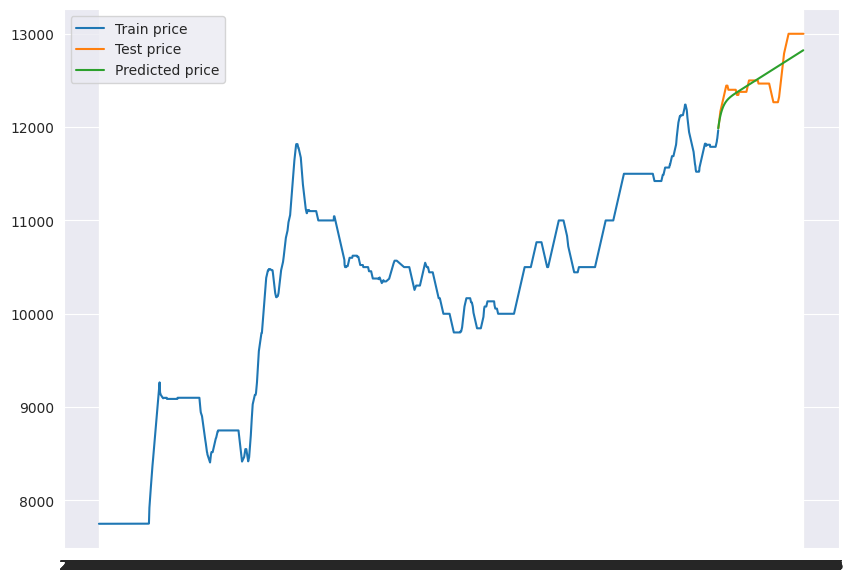

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
var_file_name = 'var_gia_lua_thoi_tiet.joblib'
varma_file_name = 'varma_gia_lua_thoi_tiet.joblib'

In [ ]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

Mounted at /content/drive


['/content/drive/MyDrive/model/var_gia_lua_thoi_tiet.joblib']